In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.nn import Linear, GRU, Conv2d, Dropout, MaxPool2d, BatchNorm1d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import folium
from folium import plugins
import seaborn as sns
import random
import requests
import math

%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable


In [3]:
from torch.distributions import Categorical
from scipy.stats import multivariate_normal

In [4]:
r = requests.get(' https://data.cityofchicago.org/resource/ijzp-q8t2.json?$limit=100000')
j = r.json()
df = pd.DataFrame.from_dict(j)
df['latitude'] = df['latitude'].astype(float)
df['longitude'] = df['longitude'].astype(float)
taxi = df[['date','latitude','longitude']].copy()
taxi = taxi.loc[taxi['longitude']  > -87.84]
taxi["year"] = taxi["date"].apply(lambda x: int( x.split("-")[0]))
taxi["month"] = taxi["date"].apply(lambda x: int( x.split("-")[1]))
taxi["day"] = taxi["date"].apply(lambda x: int( (x.split("-")[2]).split("T")[0]))
taxi["hour"] = taxi["date"].apply(lambda x: int( (x.split(":")[0]).split("T")[1]))
taxi["minutes"] = taxi["date"].apply(lambda x: int( (x.split("T")[1]).split(":")[1]))
taxi["seconds"] = taxi["date"].apply(lambda x: int( (x.split("T")[1]).split(":")[2].split(".")[0]))
taxi['position'] = list(zip(taxi.latitude, taxi.longitude))
taxi = taxi.drop(columns=['date'])

dic = {}
counter = 1
co = 0
area = []
for i in taxi['position']:
    if i not in dic:
        dic[i] = counter
        area.append(counter)
        counter += 1
    else:
        area.append(dic[i])
    co += 1
taxi['area'] = area
taxi = taxi.drop(columns=['position','area','month','minutes','seconds'])
taxi = taxi.loc[taxi['latitude']  > -87.8]
taxi['hour1'] = np.sin((taxi['hour']*2*math.pi)/24).astype('float')
taxi['hour2'] = np.cos((taxi['hour']*2*math.pi)/24).astype('float')
taxi['pickup_longitude'] = taxi['longitude'].astype('float')
taxi['pickup_latitude'] = taxi['latitude'].astype('float')
taxi = taxi.drop(columns=['longitude','latitude'])
taxi = taxi.dropna()

from sklearn.model_selection import train_test_split
taxi, test = train_test_split(taxi, test_size=0.2)
_, test1 = train_test_split(taxi, test_size = 0.25)

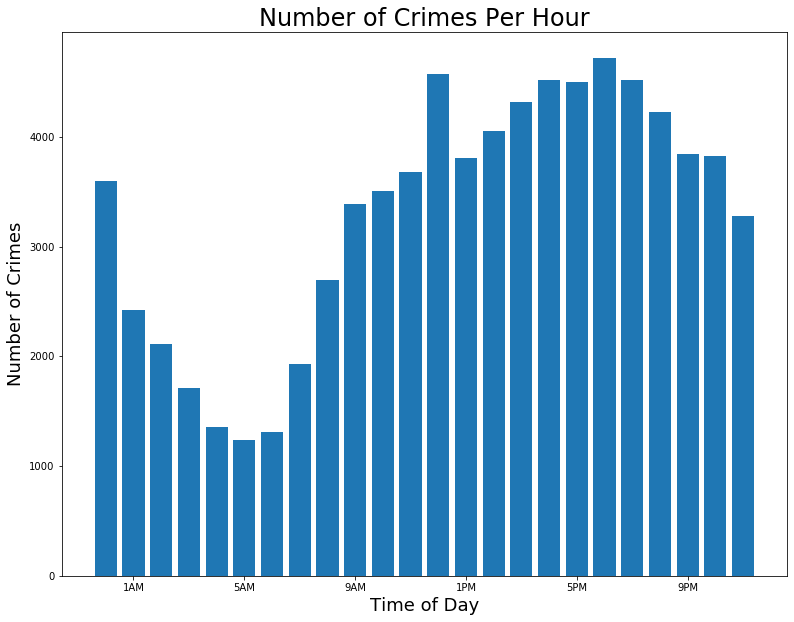

In [5]:
df431 = taxi.groupby(['hour']).size()
y = []
for i in range(len(df431)):
    y.append(df431[i])
x= range(24)
x = list(x)
objects = ('1AM', '5AM', '9AM', '1PM', '5PM', '9PM')
y_pos = np.arange(1,23,4)
plt.figure(figsize=(13, 10))
plt.bar(x,y)
plt.xticks(y_pos, objects)
plt.ylabel('Number of Crimes',fontsize=18)
plt.xlabel('Time of Day',fontsize=18)
plt.title('Number of Crimes Per Hour',fontsize=24)
plt.show()

In [6]:
m = folium.Map([41.9282,-87.7759], zoom_start=10)

pickupLocation = taxi[['pickup_latitude', 'pickup_longitude']].values
# plot heatmap
m.add_child(plugins.HeatMap(pickupLocation, radius=10))

display(m)

In [7]:
n_samples = len(taxi)
ONEOVERSQRT2PI = 1.0 / math.sqrt(2*math.pi)

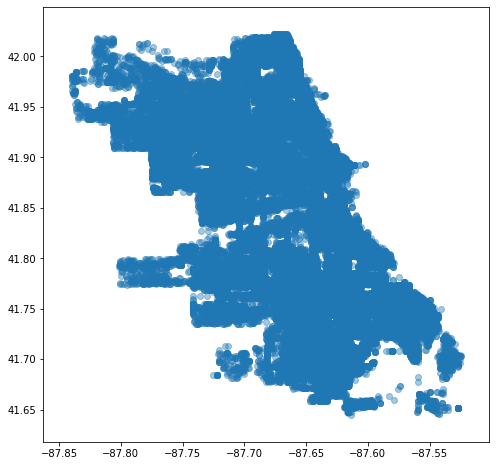

In [8]:
yx_data = torch.tensor(taxi['hour1'],dtype=torch.float)
ya_data = torch.tensor(taxi['hour2'],dtype=torch.float)
y_data = torch.stack([ yx_data,ya_data], 0)
lat = torch.tensor(taxi['pickup_latitude'],dtype=torch.float)
lon = torch.tensor(taxi['pickup_longitude'],dtype=torch.float)
plt.figure(figsize=(8, 8))
plt.scatter(lon, lat, alpha=0.4)
plt.show()
meanLat = torch.mean(lat)
meanLon = torch.mean(lon)
latAd = lat - meanLat
lonAd = lon - meanLon
x_data = torch.stack([latAd, lonAd], 1)
y_data, x_data = x_data.view(-1,2), y_data.view(-1, 2)

In [9]:
class MDN(nn.Module):
    def __init__(self, in_features, out_features, n_hidden, num_gaussians):
        super(MDN, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.num_gaussians = num_gaussians
        self.z_h = nn.Sequential(
            nn.Linear(in_features, n_hidden),
            nn.Tanh()
        )
        self.pi = nn.Linear(n_hidden, num_gaussians)
        self.sigma = nn.Linear(n_hidden, out_features*num_gaussians)
        self.mu = nn.Linear(n_hidden, out_features*num_gaussians)

    def forward(self, minibatch):
        z_h = self.z_h(minibatch)
        pi = F.softmax(self.pi(z_h), -1)
        sigma = torch.exp(self.sigma(z_h))
        sigma = sigma.view(-1, self.num_gaussians, self.out_features)
        mu = self.mu(z_h)
        mu = mu.view(-1, self.num_gaussians, self.out_features)
        return pi, sigma, mu
    
model = MDN(in_features=2, out_features = 2, n_hidden = 500, num_gaussians=20)
LEARN_R    = 7.5e-4
optimizer = optim.Adam(model.parameters())

In [10]:
def gaussian_probability(sigma, mu, target):
    target = target.unsqueeze(1).expand_as(sigma)
    ret = ONEOVERSQRT2PI * torch.exp(-0.50 * ((target - mu) / sigma)**2) / sigma
    return torch.prod(ret, 2)

In [11]:
def mdn_loss(pi, sigma, mu, target):
    eps=np.finfo(float).eps
    sigma = sigma
    prob = pi * gaussian_probability(sigma, mu, target)
    nll = -torch.log(torch.sum(prob, dim=1))
    return torch.mean(nll)

In [12]:
for epoch in range(300):
    pi1, sigma1, mu1 = model(x_data)
    loss = mdn_loss(pi1, sigma1, mu1, y_data)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
         print(loss.data.tolist())

1.8737170696258545
-2.7924442291259766
-2.7539262771606445


0


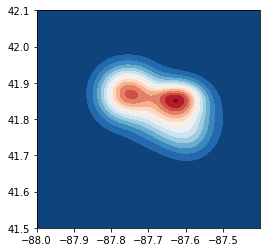

1


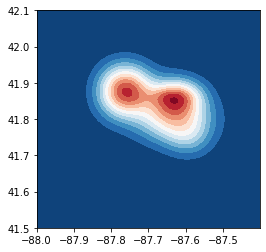

2


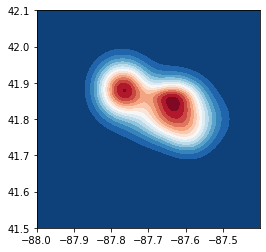

3


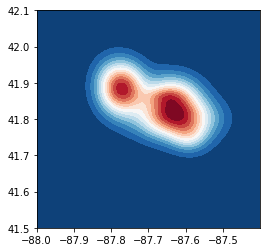

4


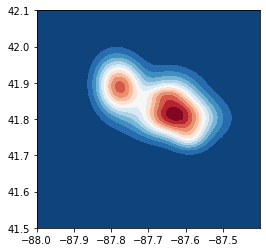

5


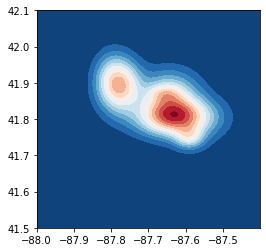

6


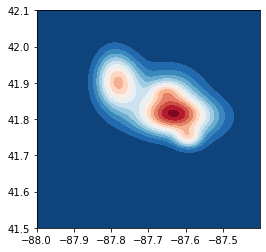

7


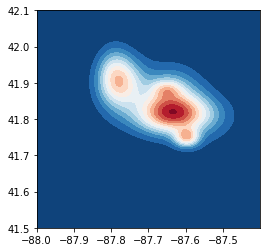

8


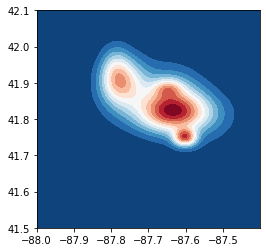

9


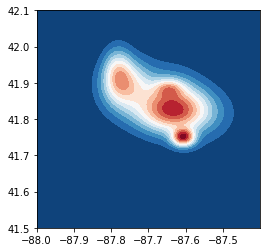

10


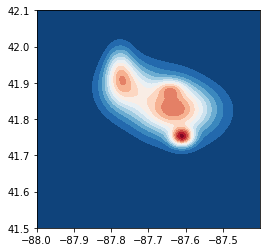

11


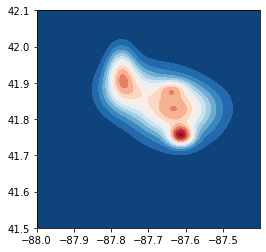

12


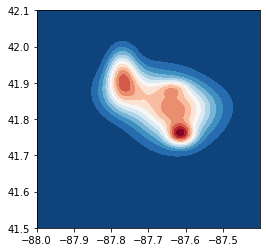

13


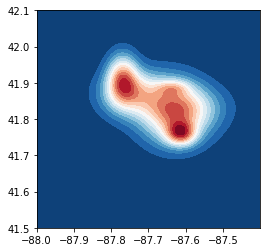

14


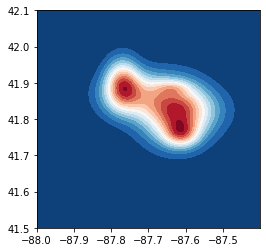

15


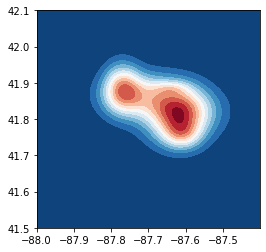

16


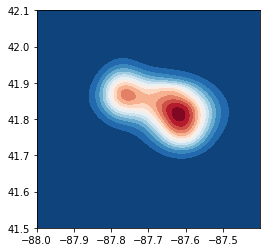

17


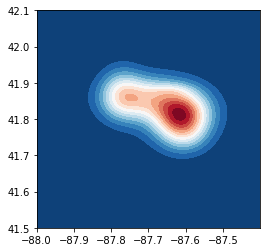

18


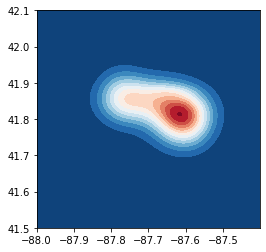

19


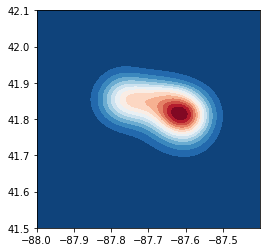

20


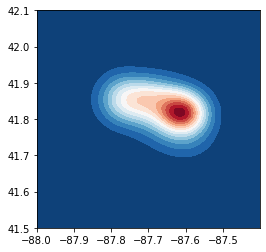

21


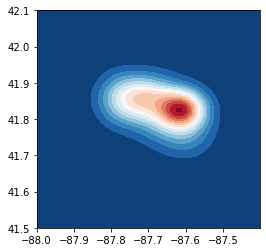

22


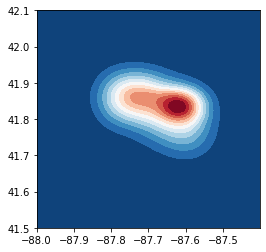

23


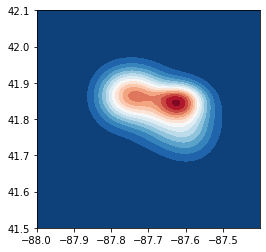

In [13]:
for j in range(24):
    #j=2
    print(j)
    #pi_0, sigma_0, mu_0 = model(torch.tensor([i]).float().view(-1,1))
    q = np.sin((j*2*math.pi)/24).astype('float')
    w = np.cos((j*2*math.pi)/24).astype('float')
    pi_0, sigma_0, mu_0 = model(torch.tensor([q,w]).float().view(-1,2))
    
    x, y = np.mgrid[-88.00:-87.40:.001, 41.50:42.10:.001]
    pos = np.dstack((x, y))
    sumProbs = np.empty((len(x),len(y)+1,))
    sumProbs[:] = 0
    fig2 = plt.figure(figsize=(4, 4))
    ax2 = fig2.add_subplot(111)
    for i in range(len(pi_0[0].tolist())):
    #for i in range(2):
        mean = [mu_0.tolist()[0][i][0] + meanLon.tolist(),mu_0.tolist()[0][i][1]+ meanLat.tolist()]        
        cov = [[sigma_0.tolist()[0][i][0]**2, 0.0], [0.0, sigma_0.tolist()[0][i][1]**2]]
        rv = multivariate_normal(mean, cov)
        probs = np.exp(rv.logpdf(pos))
        sumProbs += probs* pi_0[0][i].tolist()
    taxi2 = taxi.loc[taxi['hour'] == j]
    taxi3 = taxi2[['pickup_longitude','pickup_latitude']]
    ax2.contourf(x, y, sumProbs,cmap="RdBu_r",levels=14)
#     ax2.plot(taxi3['pickup_longitude'],taxi3['pickup_latitude'],'ko',ms=1)
    plt.show()

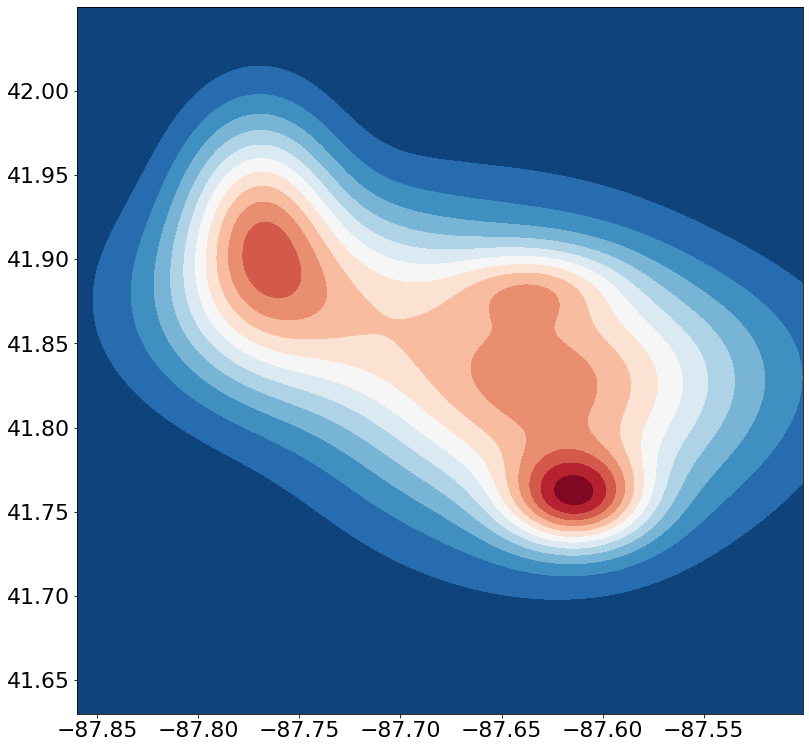

In [18]:
j=12
q = np.sin((j*2*math.pi)/24).astype('float')
w = np.cos((j*2*math.pi)/24).astype('float')
pi_0, sigma_0, mu_0 = model(torch.tensor([q,w]).float().view(-1,2))

x, y = np.mgrid[-87.86:-87.50:.001, 41.63:42.05:.001166]
pos = np.dstack((x, y))
sumProbs = np.empty((len(x),len(y)+1,))
sumProbs[:] = 0
for i in range(len(pi_0[0].tolist())):
    mean = [mu_0.tolist()[0][i][0] + meanLon.tolist(),mu_0.tolist()[0][i][1]+ meanLat.tolist()]
    cov = [[sigma_0.tolist()[0][i][0]**2, 0.0], [0.0, sigma_0.tolist()[0][i][1]**2]]
    rv = multivariate_normal(mean, cov)
    probs = np.exp(rv.logpdf(pos))
    sumProbs += probs* pi_0[0][i].tolist()
fig2 = plt.figure(figsize=(13, 13))
ax2 = fig2.add_subplot(111)
taxi2 = taxi.loc[taxi['hour'] == j]
taxi3 = taxi2[['pickup_longitude','pickup_latitude']]
ax2.contourf(x, y, sumProbs,cmap="RdBu_r",levels=14)

plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
# ax2.plot(taxi3['pickup_longitude'],taxi3['pickup_latitude'],'ko',ms=2)
plt.show()

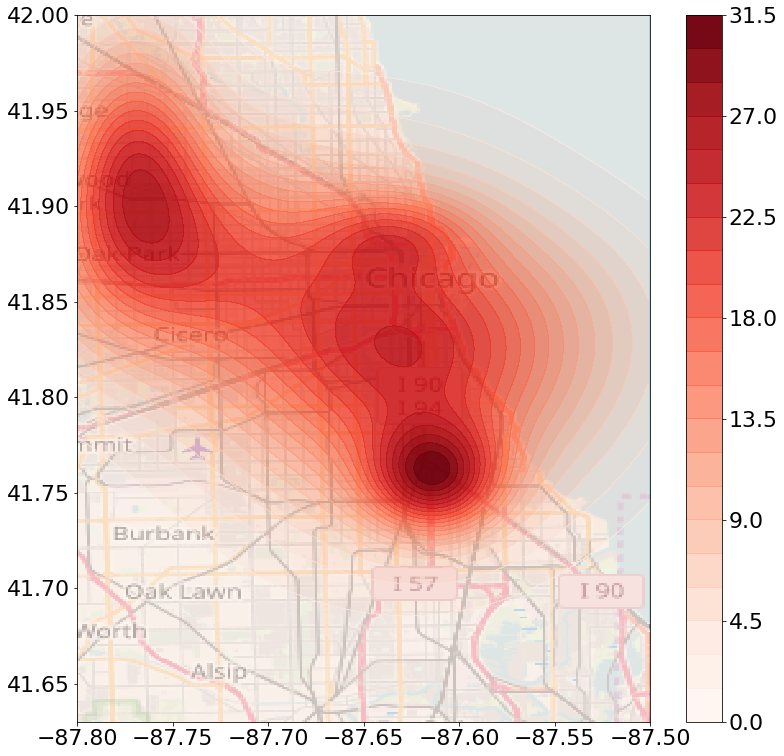

In [19]:

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from PIL import Image

def transparent_cmap(cmap, N=255):
    "Copy colormap and set alpha values"
    mycmap = cmap
    mycmap._init()
    mycmap._lut[:,-1] = np.linspace(0.6, 0.99, N+4)
    return mycmap

mycmap = transparent_cmap(plt.cm.Reds)
I = Image.open('./system_over.png')
p = np.asarray(I).astype('float')
w, h = I.size
fig2 = plt.figure(figsize=(13, 13))
ax2 = fig2.add_subplot(111)
cb = ax2.contourf(x, y, sumProbs,cmap=mycmap,levels=20)
ax2.imshow(I, extent=[-87.8, -87.50, 41.63, 42.0])
colbb = plt.colorbar(cb)
colbb.ax.tick_params(labelsize=22)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.show()

In [16]:
sMAPEList = []
sMAPENaivList = []
for q in range(24):   
    j=q
    print(j)
    #pi_0, sigma_0, mu_0 = model(torch.tensor([i]).float().view(-1,1))
    q = np.sin((j*2*math.pi)/24).astype('float')
    w = np.cos((j*2*math.pi)/24).astype('float')
    pi_0, sigma_0, mu_0 = model(torch.tensor([q,w]).float().view(-1,2))

    x, y = np.mgrid[-87.86:-87.50:.001, 41.63:42.05:.001166]
    pos = np.dstack((x, y))
    sumProbs = np.empty((len(x),len(y)+1,))
    sumProbs[:] = 0
    for i in range(len(pi_0[0].tolist())):
        mean = [mu_0.tolist()[0][i][0] + meanLon.tolist(),mu_0.tolist()[0][i][1]+ meanLat.tolist()]
        cov = [[sigma_0.tolist()[0][i][0]**2, 0.0], [0.0, sigma_0.tolist()[0][i][1]**2]]
        rv = multivariate_normal(mean, cov)
        probs = np.exp(rv.logpdf(pos))
        sumProbs += probs* pi_0[0][i].tolist()
    nx, ny = (11, 11)
    x = np.linspace(-87.86,-87.50, nx)
    y = np.linspace(41.63,42.05, ny)
    totalProbs = sum(sum(sumProbs))
    hour = j
    taxi2 = test.loc[(test['hour'] == hour)]
    taxi3 = taxi2[['pickup_longitude','pickup_latitude']]
    taxi6 = test1.loc[(test1['hour']== hour)]
    taxi7 = taxi6[['pickup_longitude','pickup_latitude']]
    realNumberOfCrimes = taxi3['pickup_longitude'].count()
    realCount = []
    naivCount = []
    probCount = []
    for i in range(len(x)-1):
        for j in range(len(y) - 1):
            realCount.append(taxi3['pickup_longitude'].\
                         loc[(taxi3['pickup_longitude'] > x[i]) & (taxi3['pickup_longitude'] < x[i+1]) & (taxi3['pickup_latitude'] > y[j]) & (taxi3['pickup_latitude'] < y[j+1])].count())
            naivCount.append(taxi7['pickup_longitude'].\
                         loc[(taxi7['pickup_longitude'] > x[i]) & (taxi7['pickup_longitude'] < x[i+1]) & (taxi7['pickup_latitude'] > y[j]) & (taxi7['pickup_latitude'] < y[j+1])].count())
            probCount.append(round(sum(sumProbs[j*36:(j+1)*36 , i*36:(i+1)*36].flatten())/totalProbs,5))
    addCountsToProbs = [round(i * realNumberOfCrimes) for i in probCount]
    taxi4 = {'estimate': addCountsToProbs, 'real': realCount, 'naiv': naivCount}
    taxi4 = pd.DataFrame(taxi4) 
    K = len(addCountsToProbs)
    sMAPE = 0
    c = 1
    for i in range(K):
        if(realCount[i] == 0 and addCountsToProbs[i] == 0):
            K -= 1
            continue
        sMAPE += (abs(realCount[i] - addCountsToProbs[i]))/(realCount[i] + addCountsToProbs[i] + c)

    sMAPE = (1/K)*sMAPE
    
    Ka = len(naivCount)
    sMAPENaiv = 0
    c = 1
    for i in range(Ka):
        if(realCount[i] == 0 and naivCount[i] == 0):
            Ka -= 1
            continue
        sMAPENaiv += (abs(realCount[i] - naivCount[i]))/(realCount[i] + naivCount[i] + c)
    sMAPENaiv = (1/Ka)*sMAPENaiv   
    sMAPENaivList.append(sMAPENaiv)
    sMAPEList.append(sMAPE)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


(array([0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45]),
 <a list of 8 Text yticklabel objects>)

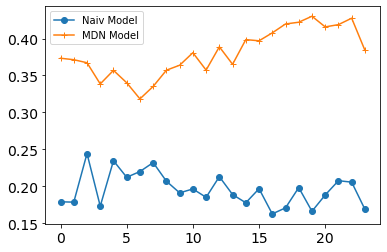

In [17]:
plt.plot(sMAPENaivList, label='Naiv Model' , marker='o' )
plt.plot(sMAPEList, label='MDN Model', marker='+' )
plt.legend()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)